*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [2]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
#except Exception:
  #pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
#!pip install tensorflow-datasets
#import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0-rc1


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [4]:
# Reading files into variable
train_data = pd.read_csv(train_file_path, sep = '\t', names = ['label','text_message'])
test_data = pd.read_csv(test_file_path, sep = '\t', names = ['label','text_message'])

In [5]:
# Subsetting the training and testing label columns from the text messages
train_label = train_data.pop('label')
test_label = test_data.pop('label')

In [6]:
# Changing the values from ham and spam to 0 and 1
train_label = train_label.replace(('ham','spam'), (0,1))
test_label = test_label.replace(('ham','spam'), (0,1))

In [7]:
# Importing tokenizer and pad sequences which will be used in tokenizing the words in our text messages
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
# Converting the data from dataframe to list as the tokenizer will only take a list
train_data = train_data['text_message'].tolist()
test_data = test_data['text_message'].tolist()
train_label = train_label.tolist()
test_label = test_label.tolist()

In [9]:
# Setting parameters
num_words = 10000
oov_token = "<OOV>"
embedding_dim = 16
max_length = 50

In [10]:
# Creating the tokenizer instance
tokenizer = Tokenizer(num_words, oov_token=oov_token)

In [11]:
# Using the tokenizer on all the words in our training data
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

In [12]:
# Using the tokenizer to create sequence of text with the tokenized words on our training and testing data

train_seq = tokenizer.texts_to_sequences(train_data)
test_seq = tokenizer.texts_to_sequences(test_data)

In [13]:
# After succesfuly tokenization of sentences, we need to pad each sentence seqence to have the same length 
padded_train = pad_sequences(train_seq, maxlen = max_length, truncating = 'post', padding = 'post')
padded_test = pad_sequences(test_seq, maxlen = max_length, truncating = 'post', padding = 'post')

In [14]:
# Before being able to pass this into the neural network, we need to convert them from list to numpy array
padded_train = np.array(padded_train)
train_label = np.array(train_label)
padded_test = np.array(padded_test)
test_label = np.array(test_label)

In [15]:
# Now it's time to build our RNN model
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim,input_length = max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [16]:
# Now we compile the model
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# The next thing is feeding our values into the model training and validation
history = model.fit(padded_train, train_label, epochs = 15, validation_data = (padded_test, test_label), verbose = 2)

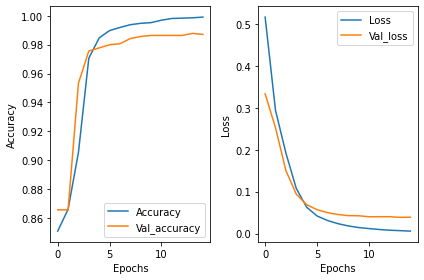

In [18]:
# Plotting the values in gotten from the training and validation of our dataset

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  text = tokenizer.texts_to_sequences([pred_text])
  text = pad_sequences(text,maxlen = max_length, truncating = 'post', padding = 'post')
  pred = model.predict(text)
  pred = pred.flatten()[0]

  prediction = [pred]
  if pred > 0.1:
    prediction.append('spam')
  else:
    prediction.append('ham')

  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.0021651983, 'ham']


In [21]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
